# <center>Statoil Kaggle competition (main notebook)</center>

### Competition link
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/

### Description
Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

### Data format

 | Column name | Description |
 |-------------|-------------|
 | id | the id of the image |
 | band_1, band_2 | the flattened image data |
 | inc_angle | the incidence angle of which the image was taken |
 | is_iceberg | the target variable, set to 1 if it is an iceberg, and 0 if it is a ship |
 
Each band has 75x75 pixel values in the list, so the list has 5625 elements. These values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically).
 
Inc_angle has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.
 
Competition score: **Log-loss**

### Motivation

2 years ago I participated in this competition and finished at 1838th place out of 3341 (top 56%). My result was 0.21476 of **Log-loss** metric on the Private Leaderboard. Two years later I decided to try to improve my score.

Here I present a simple approach with two Deep Learning models (ResNet34 and VGG19) and KNeighborsClassifier,  which showed a score of 0.11076 on the Private Leaderboard - **16th place**.

### Solution

There are two main data sources in this competition - inc_angle and images for band-1 and band-2. As shown in the notebook, ships and icebergs inc_angle values are observed in groups. KNeighborsClassifier algorithm was fitted to inc_angle data. Images were used to train ResNet34 and VGG19 Deep Learning models separately for both bands. To increase prediction score two set of pseudo labels were produced - one for use by KNeighborsClassifier and another - by Deep Learning models. Deep Learning models were trained on Google Colab. 

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

%matplotlib inline

## Data investigation (train dataset)

In [2]:
train = pd.read_json('train.json')
print(train.shape)
train.head(3)

(1604, 5)


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1


#### Plot images in both bands

In [3]:
def plot_samples(is_iceberg=True):
    # select 2 images with icebergs or ships
    i, j = np.random.choice(np.where(train.is_iceberg == int(is_iceberg))[0], size=2, replace=False)
    
    figsize(12, 8)
    fig = plt.figure()
    
    ax1 = fig.add_subplot(221)
    sns.heatmap(np.array(train.band_1.values[i]).reshape(75, 75), cmap='cubehelix', ax=ax1)
    ax1.set_title('band_1')
    ax1.axis('off')

    ax2 = fig.add_subplot(222)
    sns.heatmap(np.array(train.band_2.values[i]).reshape(75, 75), cmap='cubehelix', ax=ax2)
    ax2.set_title('band_2')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(223)
    sns.heatmap(np.array(train.band_1.values[j]).reshape(75, 75), cmap='cubehelix', ax=ax3)
    ax3.set_title('band_1')
    ax3.axis('off')

    ax4 = fig.add_subplot(224)
    sns.heatmap(np.array(train.band_2.values[j]).reshape(75, 75), cmap='cubehelix', ax=ax4)
    ax4.set_title('band_2')
    ax4.axis('off')

#### 2 icebergs

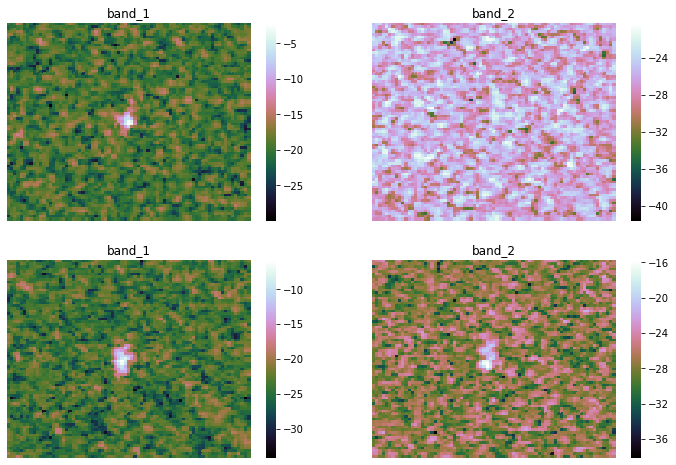

In [4]:
plot_samples(True)

#### 2 ships

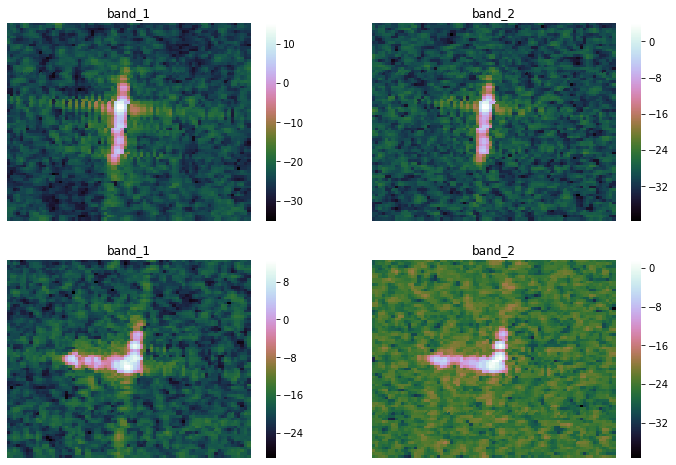

In [5]:
plot_samples(False)

#### Distribution of target

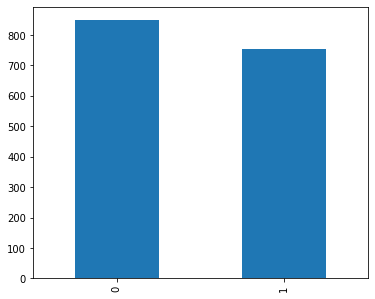

In [6]:
figsize(6, 5)
train.is_iceberg.value_counts().plot.bar()

#### inc_angle

Number of na: 133


(32, 36)

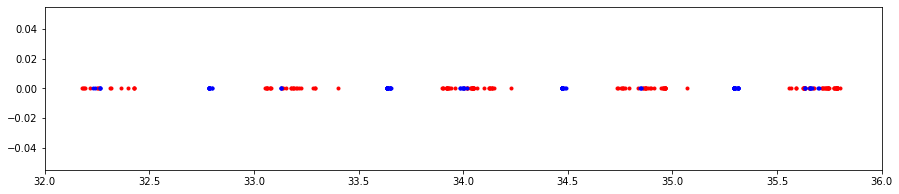

In [7]:
print('Number of na:', train[train.inc_angle=='na'].shape[0])

temp = train[(train.inc_angle!='na')]

figsize(15, 3)
plt.plot(temp[temp.is_iceberg==0].inc_angle.values, np.zeros(temp[temp.is_iceberg==0].shape[0]), 'r.')
plt.plot(temp[temp.is_iceberg==1].inc_angle.values, np.zeros(temp[temp.is_iceberg==1].shape[0]), 'b.')

plt.xlim([32, 36])

In [8]:
# It seems that icebergs and ships contain groups in inc_angle feature.
# (this was mentioned in many solutions for this Kaggle competition)

### KNeighborsClassifier on inc_angle feature
#### how accurate it's possible to predict labels based on 'inc_angle' feature only

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV

X_train = train.loc[train.inc_angle!='na', ['inc_angle']]
y_train = train.loc[train.inc_angle!='na', ['is_iceberg']]

gscv = GridSearchCV(KNeighborsClassifier(),
                    param_grid={'n_neighbors':[3, 5, 6, 7, 8, 9, 10],
                                'weights': ['uniform', 'distance'],
                                'metric':['manhattan']},
                    scoring='accuracy',
                    cv=7,
                    n_jobs=-1,
                    verbose=1).fit(X_train, y_train)

print('Best paarmeters:', gscv.best_params_)
print('Best accuracy:', gscv.best_score_)

Fitting 7 folds for each of 14 candidates, totalling 98 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s


Best paarmeters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best accuracy: 0.919782460910945


[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    3.3s finished
/home/sergei/Programms/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


### Improve signal-noice ratio of images using smoothing

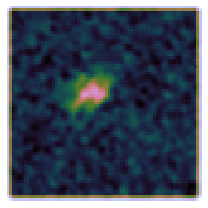

In [10]:
from scipy.signal import convolve2d

i = 6

# create numpy array from data
img = np.array(train.band_2.values[5]).reshape(75, 75)

# convolve with square kernel
kernel = np.ones([3, 3]) / 9.
img = convolve2d(img, kernel, mode='full')

figsize(3, 3)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(img, cmap='cubehelix', cbar=False, square=True, ax=ax)
plt.axis('off')
fig.tight_layout()
fig.savefig('test_{}_{}.jpg'.format(train.is_iceberg.values[i], train.id.values[i]),
            pad_inches=0, quality=100, bbox_inches='tight', dpi=20)

#### Check image size

In [11]:
from PIL import Image

pic = Image.open('test_0_9d8f326c.jpg')
pix = np.array(pic)
pix.shape

(74, 74, 3)

### Prepare images of band_1 and band_2 from train dataset 

In [12]:
from scipy.signal import convolve2d
from tqdm import tqdm

# Function to create image files from data
def band_to_image(df, is_train=True, band_name='band_1', folder_name='train'):
    # convolution kernel
    kernel = np.ones([3, 3]) / 9.
    
    for i in tqdm(range(df.shape[0])):
        # reshape values to 2D
        img = np.array(df[band_name].values[i]).reshape(75, 75)
        # smoothing using convolution
        img = convolve2d(img, kernel, mode='full')
        
        # filename
        if is_train:
            fname = '{}/{}/{}_{}.jpg'.format(folder_name, band_name, df.is_iceberg.values[i], df.id.values[i])
        else:
            fname = '{}/{}/{}.jpg'.format(folder_name, band_name, df.id.values[i])

        fig = plt.figure()
        ax = fig.add_subplot(111)
        # create a figure using seaborn
        sns.heatmap(img, cmap='cubehelix', cbar=False, square=True, ax=ax)
        # remove axis
        plt.axis('off')
        # remove layout
        fig.tight_layout()
        fig.savefig(fname, pad_inches=0, quality=100, bbox_inches='tight', dpi=20)

In [13]:
!mkdir train
!mkdir train/band_1
!mkdir train/band_2

In [14]:
band_to_image(train, is_train=True, band_name='band_1', folder_name='train')

In [15]:
band_to_image(train, is_train=True, band_name='band_2', folder_name='train')

## Explore test dataset

In [16]:
test = pd.read_json('test.json')
print(test.shape)
test.head()

(8424, 4)


,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [17]:
# Some images in the test dataset were machine generated.
#
# Looking at band_1 and band_2 data it becomes clear that some rows have the same number of digits
# as in the train dataset and others - much more digits. Plotting the lenght of a string generated
# from band_1 and band_2 data it's easy to find those 5000 machine generated images. They won't
# be scored and therefore I can just remove them from the test dataset.

Text(0.5, 1.0, 'test')

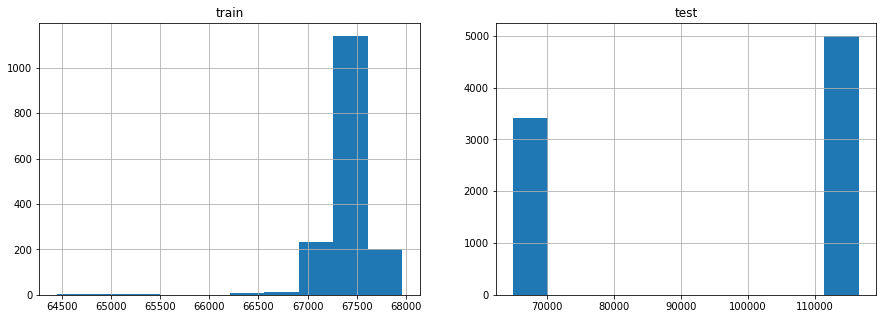

In [18]:
figsize(15, 5)
fig = plt.figure()

ax1 = fig.add_subplot(121)
train.band_1.apply(lambda x: len(str(x))).hist(ax=ax1)
ax1.set_title('train')

ax2 = fig.add_subplot(122)
test.band_1.apply(lambda x: len(str(x))).hist(ax=ax2)
ax2.set_title('test')

#### remove machine generated images

In [19]:
test = (test
        .assign(is_real = lambda x: [len(str(y)) for y in x.band_1.values])
        .loc[lambda x: x.is_real < 80000, ['id', 'band_1', 'band_2', 'inc_angle']]
       )
print('Number of images in test:', test.shape[0])
test.head(3)

Number of images in test: 3424


,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.9664
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.4739
6,29e7727e,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",42.4142


#### save only real images

In [20]:
test.to_json('test_real.json')
test.shape

(3424, 4)

In [21]:
test_real = pd.read_json('test_real.json')
test_real.head()

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.9664
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.4739
6,29e7727e,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",42.4142
7,92a51ffb,"[-20.162964, -18.16898, -17.023144, -17.023216...","[-30.905346, -28.406647, -25.381365, -28.77645...",33.6383
8,c769ac97,"[-21.920645, -21.737827, -21.383303, -21.73792...","[-25.53537, -28.514198, -27.75848, -31.280354,...",41.1076


### Prepare images of band_1 and band_2 from test_real dataset 

In [22]:
!mkdir test
!mkdir test/band_1
!mkdir test/band_2

In [23]:
band_to_image(test_real, is_train=False, band_name='band_1', folder_name='test')

In [24]:
band_to_image(test_real, is_train=False, band_name='band_2', folder_name='test')

## Prepare pseudo labels based on two Deep Learning models predictions

The idea was to train two Deep Learning models on the train dataset and predict labels for the test dataset. I will save only labels which belong to an iceberg or a ship with 95% probability. These pseudo labels will be used later for fitting **KNeighborsClassifier** and making predictions based on inc_angle only.

In [25]:
test11 = pd.read_csv('resnet34_test_band_1_result.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))
test12 = pd.read_csv('resnet34_test_band_2_result.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))

test21 = pd.read_csv('vgg16_test_band_1_result.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))
test22 = pd.read_csv('vgg16_test_band_2_result.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))

In [26]:
pseudo_angle = (test_real
  # merge all prediction for the test
 .merge(test11.rename(columns={'pred':'pred1'}), on='id')
 .merge(test12.rename(columns={'pred':'pred2'}), on='id')
 .merge(test21.rename(columns={'pred':'pred3'}), on='id')
 .merge(test22.rename(columns={'pred':'pred4'}), on='id')
 .loc[:, ['pred1', 'pred2', 'pred3', 'pred4', 'id', 'inc_angle']]
  # assign labels
 .assign(is_iceberg = lambda x: [1 if max(y1, y3) > 0.95 and max(y2, y4) > 0.95 else 0 if min(y1, y3) < 0.05 and min(y2, y4) < 0.05 else -1 for y1,y2,y3,y4 in zip(x.pred1, x.pred2, x.pred3, x.pred4)])
  # select only confident labels
 .loc[lambda x: x.is_iceberg > -1, :]
 .loc[:, ['inc_angle', 'is_iceberg']]
)

pseudo_angle = pd.concat([pseudo_angle, train.loc[train.inc_angle!='na', ['inc_angle', 'is_iceberg']]], axis=0)
pseudo_angle.shape

(2860, 2)

#### Plot true labels from the train dataset and pseudo labels from the test one

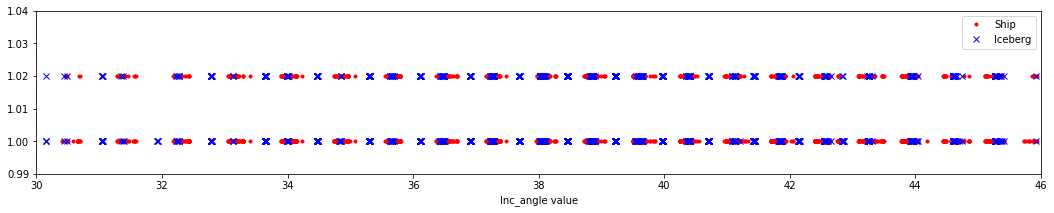

In [27]:
figsize(18, 3)

# train
plt.plot(train[(train.inc_angle!='na') & (train.is_iceberg==0)].inc_angle,
         1.02*np.ones(train[(train.inc_angle!='na') & (train.is_iceberg==0)].shape[0]),
         'r.', label='Ship')

plt.plot(train[(train.inc_angle!='na') & (train.is_iceberg==1)].inc_angle,
         1.02*np.ones(train[(train.inc_angle!='na') & (train.is_iceberg==1)].shape[0]),
         'bx', label='Iceberg')

# test
plt.plot(pseudo_angle[pseudo_angle.is_iceberg==0].inc_angle,
         np.ones(pseudo_angle[pseudo_angle.is_iceberg==0].shape[0]), 'r.')
         
plt.plot(pseudo_angle[pseudo_angle.is_iceberg==1].inc_angle,
         np.ones(pseudo_angle[pseudo_angle.is_iceberg==1].shape[0]), 'bx')

plt.legend()

plt.xlim([30, 46])
plt.ylim([0.99, 1.04])
_ = plt.xlabel('Inc_angle value')

## Prepare another set of pseudo labels based on inc_angle

I will assign corresponding labels for records in the test dataset in case these rules are true:
 - there are some labels in both train and pseudo labels in the interval (inc_angle - eps, inc_angle + eps);
 - all labels in this interval are ships or all labels are icebergs.
 
I'm going to use these new pseudo labels to increase training dataset for Deep Leearning models.

In [28]:

# I added one artificial point to include obvious icebergs in the area missed in the train
train_angle = np.r_[train[train.inc_angle!='na'].inc_angle.values, np.array([31.93])]
train_labels = np.r_[train[train.inc_angle!='na'].is_iceberg.values, np.array([1])]

# pseudo labels
valid_angle = pseudo_angle.inc_angle.values
valid_labels = pseudo_angle.is_iceberg.values

test_angle = test_real.inc_angle.values
test_labels = -1 * np.ones(test_real.shape[0])

eps = 0.03

for i in range(len(test_angle)):
    train_ind = np.where((train_angle > test_angle[i] - eps) & (train_angle < test_angle[i] + eps))[0]
    valid_ind = np.where((valid_angle > test_angle[i] - eps) & (valid_angle < test_angle[i] + eps))[0]
    
    if (len(train_ind) > 0) and (len(valid_ind) > 0):
        if (train_labels[train_ind] == 0).all() and (valid_labels[valid_ind] == 0).all():
            test_labels[i] = 0
        elif (train_labels[train_ind] == 1).all() and (valid_labels[valid_ind] == 1).all():
            test_labels[i] = 1
        else:
            continue
            
print('Number of pseudo labels:', len(np.where(test_labels!=-1)[0]))

Number of pseudo labels: 1720


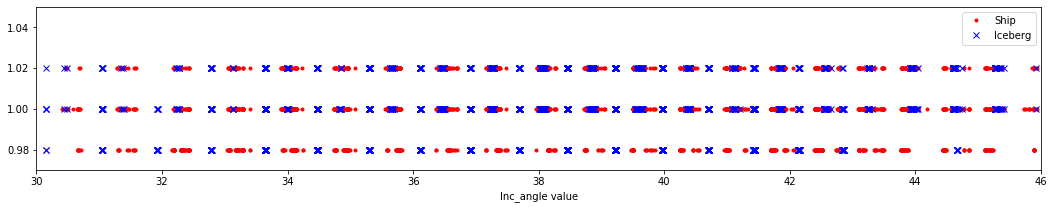

In [29]:
# Plot the following:
# 1) true labels from the train dataset
# 2) pseudo labels from the test dataset (based on models predictions)
# 3) pseudo labels from the test dataset (based on inc_angle)

figsize(18, 3)

plt.plot(train[(train.inc_angle!='na') & (train.is_iceberg==0)].inc_angle,
         1.02*np.ones(train[(train.inc_angle!='na') & (train.is_iceberg==0)].shape[0]),
         'r.', label='Ship')

plt.plot(train[(train.inc_angle!='na') & (train.is_iceberg==1)].inc_angle,
         1.02*np.ones(train[(train.inc_angle!='na') & (train.is_iceberg==1)].shape[0]),
         'bx', label='Iceberg')


plt.plot(pseudo_angle[pseudo_angle.is_iceberg==0].inc_angle,
         np.ones(pseudo_angle[pseudo_angle.is_iceberg==0].shape[0]), 'r.')
         
plt.plot(pseudo_angle[pseudo_angle.is_iceberg==1].inc_angle,
         np.ones(pseudo_angle[pseudo_angle.is_iceberg==1].shape[0]), 'bx')


ind0 = np.where(test_labels == 0)[0]
plt.plot(test_angle[ind0], 0.98*np.ones(len(ind0)), 'r.')

ind1 = np.where(test_labels == 1)[0]
plt.plot(test_angle[ind1], 0.98*np.ones(len(ind1)), 'bx')

plt.legend()

plt.xlabel('Inc_angle value')
plt.xlim([30, 46])
_ = plt.ylim([0.97, 1.05])

### Prepare images of band_1 and band_2 from pseudo labels from the test_real dataset 

In [30]:
!mkdir train_pseudo
!mkdir train_pseudo/band_1
!mkdir train_pseudo/band_2

In [31]:
# assign pseudo labels to include in filenames
test_real['is_iceberg'] = test_labels.astype(int)
test_real.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.9664,0
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.4739,1
6,29e7727e,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",42.4142,0
7,92a51ffb,"[-20.162964, -18.16898, -17.023144, -17.023216...","[-30.905346, -28.406647, -25.381365, -28.77645...",33.6383,1
8,c769ac97,"[-21.920645, -21.737827, -21.383303, -21.73792...","[-25.53537, -28.514198, -27.75848, -31.280354,...",41.1076,-1


In [32]:
band_to_image(test_real[test_real.is_iceberg!=-1], is_train=True, band_name='band_1', folder_name='train_pseudo')

In [33]:
band_to_image(test_real[test_real.is_iceberg!=-1], is_train=True, band_name='band_2', folder_name='train_pseudo')

## Train KNeighborsClassifier on pseudo labelled 'inc_angle' data

#### find best parameters

In [34]:
X_train, y_train = pseudo_angle[['inc_angle']], pseudo_angle[['is_iceberg']]

gscv = GridSearchCV(KNeighborsClassifier(),
                    param_grid={'n_neighbors':[5, 6, 7, 8, 9, 10],
                                'weights': ['uniform', 'distance'],
                                'metric':['manhattan']},
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1,
                    verbose=1).fit(X_train, y_train)

print('Best parameters:', gscv.best_params_)
print('Best score:', gscv.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best score: 0.9370629370629371


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
/home/sergei/Programms/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


## Prepare final train and test datasets to make predictions

#### download all predictions

In [35]:
# Resnet34 model
train11 = pd.read_csv('resnet34_train_pseudo_band_1.csv').assign(id=lambda x: x.id.apply(lambda y: y[26:]))
train12 = pd.read_csv('resnet34_train_pseudo_band_2.csv').assign(id=lambda x: x.id.apply(lambda y: y[26:]))

test11 = pd.read_csv('resnet34_test_pseudo_band_1.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))
test12 = pd.read_csv('resnet34_test_pseudo_band_2.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))

# VGG19 model
train21 = pd.read_csv('vgg19_train_pseudo_band_1.csv').assign(id=lambda x: x.id.apply(lambda y: y[26:]))
train22 = pd.read_csv('vgg19_train_pseudo_band_2.csv').assign(id=lambda x: x.id.apply(lambda y: y[26:]))

test21 = pd.read_csv('vgg19_test_pseudo_band_1.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))
test22 = pd.read_csv('vgg19_test_pseudo_band_2.csv').assign(id=lambda x: x.id.apply(lambda y: y[23:]))

#### prepare X_train

In [36]:
X_train = (train11.rename(columns={'pred':'pred1'})
           .merge(train12.rename(columns={'pred':'pred2'}), on='id')
           .merge(train21.rename(columns={'pred':'pred3'}), on='id')
           .merge(train22.rename(columns={'pred':'pred4'}), on='id')
          )

# double check that test_real has pseudo labels
test_real['is_iceberg'] = test_labels

# Pseudo labels dataset include images from both train and test
# I need to prepare them separately before merging together
X_train = (pd.concat([X_train.merge(train.loc[train.inc_angle!='na', ['id', 'inc_angle', 'is_iceberg']], on='id'),
                      X_train.merge(test_real[['id', 'inc_angle', 'is_iceberg']], on='id')], axis=0)
     .loc[lambda x: x.is_iceberg!=-1, :]
     .reset_index(drop=True)
    )

#### predict a new feature using KNeighborsClassifier on inc_angle

In [37]:
from sklearn.model_selection import cross_val_predict

X_train['pred9'] = cross_val_predict(
    KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance'),
    X_train[['inc_angle']], X_train['is_iceberg'],
    cv=7,
    method='predict_proba')[:, 1]

print(X_train.shape)
X_train.head(10)

(3172, 8)


,pred1,id,pred2,pred3,pred4,inc_angle,is_iceberg,pred9
0,0.992291,ba54a7ea,9.928081e-01,0.998992,0.999698,42.1431,1.0,1.000000
1,0.243121,7b489754,7.761993e-01,0.314563,0.787349,40.3904,1.0,1.000000
2,0.504620,bffad1b6,4.258040e-02,0.701945,0.078344,37.9814,0.0,0.063132
3,0.974476,71ca7993,6.126525e-01,0.940602,0.718810,40.7118,1.0,1.000000
4,0.972486,6738197b,9.953297e-01,0.981141,0.966694,36.4332,1.0,0.081869
5,0.000004,ae143d1e,2.188271e-05,0.000007,0.000023,41.8582,0.0,0.000000
6,0.000002,b49797c9,3.652587e-07,0.000586,0.000001,45.1485,0.0,0.000000
7,0.180339,4b453753,5.409859e-01,0.291674,0.649132,41.9194,0.0,0.000000
8,0.567515,e90038aa,4.408156e-01,0.885607,0.327080,35.6588,1.0,0.218768
9,0.087740,ff3e8685,4.993195e-01,0.684793,0.524525,41.0834,1.0,0.753533


In [38]:
# train KNeighborsClassifier on full X_train
kn = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
kn.fit(X_train[['inc_angle']], X_train['is_iceberg'])

X_test = (test11.rename(columns={'pred':'pred1'})
          .merge(test12.rename(columns={'pred':'pred2'}), on='id')
          .merge(test21.rename(columns={'pred':'pred3'}), on='id')
          .merge(test22.rename(columns={'pred':'pred4'}), on='id')
          .merge(test_real[['id', 'inc_angle']], on='id')
          .assign(pred9 = lambda x: kn.predict_proba(x.inc_angle.values.reshape(-1, 1))[:, 1])
         )

X_test

,pred1,id,pred2,pred3,pred4,inc_angle,pred9
0,0.340790,440673b9,0.402169,0.290911,0.337729,37.2752,0.910714
1,0.037754,0129bddd,0.334795,0.087969,0.347657,44.6687,1.000000
2,0.903734,ea31b4aa,0.339879,0.961013,0.338537,41.7082,0.000000
3,0.127579,f83a50d9,0.264395,0.426099,0.294008,41.2905,0.000000
4,0.997545,1ffbf411,0.595084,0.887264,0.822623,39.6495,0.101614
...,...,...,...,...,...,...,...
3419,0.964431,f50e51a2,0.658353,0.947890,0.865765,38.2584,0.000000
3420,0.998196,c52ad74d,0.999999,0.999982,0.998749,35.2987,1.000000
3421,0.515402,8f02a023,0.438417,0.564764,0.194388,39.5009,0.000000
3422,0.063890,c4ad51c9,0.000331,0.012623,0.000838,35.7626,0.000000


## Train LogisticRegression and make predictions

In [39]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

lr = LogisticRegressionCV(Cs=np.logspace(-5, 2, 30),
                          scoring='neg_log_loss',
                          cv=7,
                          class_weight='balanced')
lr.fit(X_train.loc[:, X_train.columns[~X_train.columns.isin(['is_iceberg', 'inc_angle', 'id'])]], X_train['is_iceberg'])

LogisticRegressionCV(Cs=array([1.00000000e-05, 1.74332882e-05, 3.03919538e-05, 5.29831691e-05,
       9.23670857e-05, 1.61026203e-04, 2.80721620e-04, 4.89390092e-04,
       8.53167852e-04, 1.48735211e-03, 2.59294380e-03, 4.52035366e-03,
       7.88046282e-03, 1.37382380e-02, 2.39502662e-02, 4.17531894e-02,
       7.27895384e-02, 1.26896100e-01, 2.21221629e-01, 3.85662042e-01,
       6.72335754e-01, 1.17...0, 3.56224789e+00,
       6.21016942e+00, 1.08263673e+01, 1.88739182e+01, 3.29034456e+01,
       5.73615251e+01, 1.00000000e+02]),
                     class_weight='balanced', cv=7, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
                     verbose=0)

In [40]:
lr.C_

array([2.04335972])

In [41]:
lr = LogisticRegression(C=2.04, class_weight='balanced')
lr.fit(X_train.loc[:, X_train.columns[~X_train.columns.isin(['is_iceberg', 'inc_angle', 'id'])]], X_train['is_iceberg'])

/home/sergei/Programms/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=2.04, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
result = (pd.DataFrame()
          .assign(id=X_test.id,
                  is_iceberg = lr.predict_proba(X_test.loc[:, X_test.columns[~X_test.columns.isin(['inc_angle', 'id'])]])[:, 1])
      )
result.head()

,id,is_iceberg
0,440673b9,0.686442
1,0129bddd,0.485877
2,ea31b4aa,0.281319
3,f83a50d9,0.015073
4,1ffbf411,0.806946


#### distribution of predicted probabilities

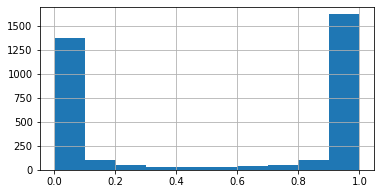

In [43]:
figsize(6, 3)
result.is_iceberg.hist()

#### submission

In [44]:
(pd.read_csv('sample_submission.csv')
 .loc[:, ['id']]
 .merge(result, on='id', how='left')
 # assign 0.5 to machine generated images
 .fillna(value=0.5)
).to_csv('submission_final.csv', index=False)

## Appendix
### Model GaussianMixture of ships and icebergs

Text(0, 0.5, 'Inc_angle')

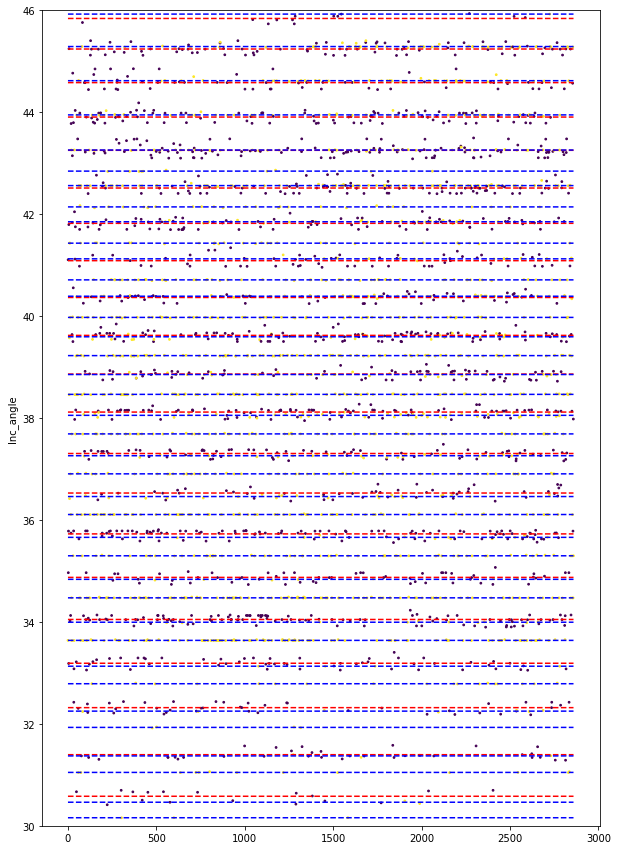

In [50]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

def get_trained_model(X, eps=0.1):
    # find centers
    db = DBSCAN(eps=eps, min_samples=1).fit(X.inc_angle.values.reshape(-1, 1))
    X['label'] = db.labels_

    # center locations
    gm_means = (X.groupby('label')
                .agg({'inc_angle':lambda x: np.mean(x)})
                .inc_angle
                .values
                .reshape(-1, 1)
               )

    # fit GaussianMixture model
    gm = GaussianMixture(n_components=len(np.unique(db.labels_)), means_init=gm_means)
    gm.fit(X.inc_angle.values.reshape(-1, 1))
    
    return gm

# models
gm0 = get_trained_model(pseudo_angle[(pseudo_angle.is_iceberg==0) & (pseudo_angle.inc_angle > 30)], eps=0.15)
gm1 = get_trained_model(pseudo_angle[(pseudo_angle.is_iceberg==1) & (pseudo_angle.inc_angle > 30)], eps=0.1)


figsize(10, 15)

# plot centers for ships
for i in range(gm0.means_.shape[0]):
    plt.plot(range(pseudo_angle.shape[0]), np.ones(pseudo_angle.shape[0])*gm0.means_[i][0], 'r--')
    
# plot centers for icebergs
for i in range(gm1.means_.shape[0]):
    plt.plot(range(pseudo_angle.shape[0]), np.ones(pseudo_angle.shape[0])*gm1.means_[i][0], 'b--')

# all samples
plt.scatter(range(len(pseudo_angle)), pseudo_angle.inc_angle, c=pseudo_angle.is_iceberg, s=3)
plt.ylim([30, 46])
plt.ylabel('Inc_angle')

### Estimate accuracy of prediction

In [51]:
from sklearn.metrics import accuracy_score

temp = (pseudo_angle
 .loc[:, ['inc_angle', 'is_iceberg']]
 .assign(lh0 = gm0.score_samples(pseudo_angle.inc_angle.values.reshape(-1, 1)),
         lh1 = gm1.score_samples(pseudo_angle.inc_angle.values.reshape(-1, 1)))
 .assign(pred = lambda x: [1 if y > z else 0 for y, z in zip(x.lh1, x.lh0)])
 .assign(pred = lambda x: [0 if y < 30 else z for y, z in zip(x.inc_angle, x.pred)])
)

accuracy_score(temp.is_iceberg, temp.pred)

0.8982517482517482